In [2]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import gcf
import seaborn as sns
import scipy.stats
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy import stats
import urllib.request
import mdtraj as md
import scipy as sp
sns.set_style("darkgrid")

In [3]:
def get_chi1_angles(pdb):
        pdb = md.load_pdb(pdb)
        topology = pdb.topology
        table, bonds = topology.to_dataframe()
        ch1_pos, ch1_rad = md.compute_chi1(pdb)[0], md.compute_chi1(pdb)[1]
        chi_1_angles = np.degrees(ch1_rad)
        res = [table['resName'][ch1_pos[res][-1]] for res in range(len(ch1_pos))]
        n = [table['resSeq'][ch1_pos[res][-1]] for res in range(len(ch1_pos))]
        pos = [list(a) for a in zip(n,res)]
        return chi_1_angles, pos

def conv_to_np_arr_new(list_angles):
    mean_angles = np.array([])
    max_val = max(len(elem) for elem in list_angles)
    for i in range(len(list_angles)):
        len_ls = len(list_angles[i])
        if len_ls < max_val:
            arr_2nan = np.empty((1,max_val-len_ls))
            arr_2nan[:] = 0
            list_angles[i] = np.append(list_angles[i],arr_2nan)
    degs =  np.vstack((list_angles))
    av_sin = np.mean(np.sin(degs * np.pi / 180.),axis=0)
    av_cos = np.mean(np.cos(degs * np.pi / 180.),axis=0)
    mean_angles = np.rad2deg(np.arctan2(av_sin,av_cos))
    mean_angles[mean_angles <= -120] += 360
    return list_angles, mean_angles

def conv_to_np_arr_old(list_angles):
    max_val = max(len(elem) for elem in list_angles)
    for i in range(len(list_angles)):
        len_ls = len(list_angles[i])
        if len_ls < max_val:
            arr_2nan = np.empty((1,max_val-len_ls))
            arr_2nan[:] = 0
            list_angles[i] = np.append(list_angles[i],arr_2nan)
    return list_angles

# Correlation of Vector
def correlations_vector(score1, score2):
    # Declaring y and x to append mave_data comp_data, respectively.
    y=[]; x=[]
    # Looping through NaNs and inly appending non NaNs to y and x
    for i in range(score1.shape[0]):
        if np.isnan(score1[i]) or np.isnan(score2[i]):
            pass
        else:
            x.append(float(score1[i]))
            y.append(float(score2[i]))
    # Converting to np arrays and calculating pearson and spearman correalation.
    x=np.array(x)
    y=np.array(y)
    r=sp.stats.pearsonr(x,y)
    s,p=sp.stats.spearmanr(x,y)
    print("Pearson's correlation coefficient between data: ",abs(r[0]))
    print("Spearman's correlation coefficient bewteen data: " ,abs(s))

    return [abs(r[0]),abs(s)]

# Correlation of Matrix
def correlations_matrix(score1, score2):
    # Declaring y and x to append mave_data comp_data, respectively.
    y=[]; x=[]

    # Looping through NaNs and inly appending non NaNs to y and x
    for i in range(score1.shape[0]):
        for j in range(score1.shape[1]):
            if np.isnan(score1[i,j]) or np.isnan(score2[i,j]):
                pass
            else:
                x.append(float(score1[i,j]))
                y.append(float(score2[i,j]))
    # Converting to np arrays and calculating pearson and spearman correalation.
    x=np.array(x)
    y=np.array(y)
    r=sp.stats.pearsonr(x,y)
    s,p=sp.stats.spearmanr(x,y)
    print("Pearson's correlation coefficient between data: ",abs(r[0]))
    print("Spearman's correlation coefficient bewteen data: " ,abs(s))

    return [abs(r[0]),abs(s)]

# Load RMSDs from file
def load_rmsd(path, pdbs):
    dir_list = sorted(os.listdir(path))
    rmsd_list = np.zeros(len(dir_list))
    mut_list = [0]*len(dir_list)
    for i in range(len(dir_list)):
        df = pd.read_csv(path + dir_list[i])['rmsd'][0]
        rmsd_list[i] = df
        if 'af2' in path:
            df1 = pd.read_csv(path + dir_list[i])['mut'][0]
            mut_list[i] = df1
    return rmsd_list, mut_list

# Load torsion angles for PDBs
def compile_angles_pdb(path):
    filenames = list()
    dir_list = sorted(os.listdir(path))
    angles_list = list()
    pos_list = list()
    for i in range(1,len(dir_list)):
        chi1_angle, pos = get_chi1_angles(path + dir_list[i])
        chi1_angle = chi1_angle.squeeze()
        angles_list.append(chi1_angle)
        filenames.append(dir_list[i])
        pdb = md.load_pdb(path + dir_list[i])
        topology = pdb.topology
        table, bonds = topology.to_dataframe()
        pos_list.append(pos)
    return angles_list, filenames, pos_list

# Load torsion angles for af 2
def compile_angles_af2(path, pdbs):
    filenames = list()
    dir_list = sorted(os.listdir(path))
    angles_list = list()
    pos_list = list()
    plddt_list = list()
    for k in range(len(dir_list)):
        for pdb in pdbs:
            if pdb in dir_list[k]:
                tmp_dir_list = os.listdir(path + '/' + dir_list[k])    
                pdb_file = [file for file in  tmp_dir_list if 'rank_1' in file and '.pdb' in file]
                # Read pLDDT scores
                plddt_file = [file for file in  tmp_dir_list if 'rank_1' in file and '.json' in file]
                plddt_df = pd.read_json(path + '/' + dir_list[k] + '/' + plddt_file[0])
                plddt_ls = plddt_df['plddt'].tolist()
                plddt_list.append(plddt_ls)
                filenames.append(pdb_file[0])
                chi1_angle, pos = get_chi1_angles(path + '/' + dir_list[k] + '/' + pdb_file[0])
                chi1_angle = chi1_angle.squeeze()
                angles_list.append(chi1_angle)
                pos_list.append(pos)
    return angles_list, filenames, pos_list, plddt_list

def circ_meanscatter_plot(x_ls,y_ls, plddt):
    X, X_means = conv_to_np_arr_new(x_ls)
    Y, Y_means = conv_to_np_arr_new(y_ls)
    print(X_means.shape, Y_means.shape)
    #fig = plt.figure()
    plddt_mean = np.mean(plddt_indexed,axis=0)
    #kernel = gaussian_kde(plddt_mean)
    #kde = kernel.evaluate(plddt_mean)
    #norm = Normalize(vmin=kde.min(), vmax=kde.max())
    #colors = plt.cm.ScalarMappable(norm=norm, cmap='GnBu').to_rgba(kde)
    colormap = plt.cm.get_cmap('GnBu') # 'plasma' or 'viridis'
    colors = colormap(plddt_mean)    
    
    plt.title('P00720',fontsize=12)
    plt.xlabel('$\chi_1$ AF2 [$^\circ$]',fontsize=12)
    plt.ylabel('$\chi_1$ X-ray [$^\circ$]',fontsize=12)
    plt.xlim(-120,250)
    plt.ylim(-120,250)
    trend = np.polyfit(X_means,Y_means,1)
    trendpoly = np.poly1d(trend) 
    scatter_plot = plt.scatter(X_means, Y_means, vmin=0, vmax=X_means.max(), c=colors)
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=0, vmax=100)
    plt.colorbar(sm, label='pLDDT')
    plt.plot(X_means,trendpoly(X_means), c='black', label = 'ρ = 0.86')
    plt.legend(fontsize=14, loc="upper left")
    plt.savefig("/Users/holger/Desktop/master_thesis/notebooks/figs/chi1_plot_P00720_wt.pdf")
    
    print(X_means.shape, Y_means.shape)
    return correlations_vector(X_means, Y_means)

def scatter_plot(x_ls,y_ls):
    X=np.stack(conv_to_np_arr_old(x_ls))
    Y=np.stack(conv_to_np_arr_old(y_ls))
    print(np.nanmean(X, axis=0))
    values = np.vstack((np.nanmean(X, axis=0), np.nanmean(Y, axis=0)))
    kernel = gaussian_kde(values)
    kde = kernel.evaluate(values)
    norm = Normalize(vmin=kde.min(), vmax=kde.max())
    colors = cm.ScalarMappable(norm=norm, cmap='viridis_r').to_rgba(kde)
    plt.title('P00720',fontsize=12)
    plt.xlabel('$\chi_1$ AF2 [$^\circ$]',fontsize=12)
    plt.ylabel('$\chi_1$ X-ray [$^\circ$]',fontsize=12)

    trend = np.polyfit(np.nanmean(X, axis=0),np.nanmean(Y, axis=0),1)
    trendpoly = np.poly1d(trend) 
    plt.scatter(np.nanmean(X, axis=0), np.nanmean(Y, axis=0), c=colors)
    plt.plot(np.nanmean(X, axis=0),trendpoly(np.nanmean(X, axis=0)), c='black', label = 'ρ = 0.63')
    plt.legend(fontsize=14, loc="upper left")
    plt.savefig("/Users/holger/Desktop/master_thesis/notebooks/figs/chi1_plot_P00720.png", dpi=1200)
    
    return correlations_matrix(X, Y)

def mean_plddt(path, pdbs):
    filenames = list()
    dir_list = sorted(os.listdir(path))
    plddt_mean_ls = list()
    for k in range(len(dir_list)):
        for pdb in pdbs:
            if pdb in dir_list[k]:
                tmp_dir_list = os.listdir(path + '/' + dir_list[k])    
                pdb_file = [file for file in  tmp_dir_list if 'rank_1' in file and '.pdb' in file]
                # Read pLDDT scores
                plddt_file = [file for file in  tmp_dir_list if 'rank_1' in file and '.json' in file]
                print(plddt_file[0])
                plddt_df = pd.read_json(path + '/' + dir_list[k] + '/' + plddt_file[0])
                plddt_ls = plddt_df['plddt'].mean()
                plddt_mean_ls.append(plddt_ls)
                filenames.append(pdb_file[0])
    mean_arr = np.asarray(plddt_mean_ls)
    mean = np.mean(plddt_mean_ls)
    return mean

In [4]:
# Define consts
DATA_PATH_MUT_AF2 = '/Users/holger/Desktop/master_thesis/data/results_rmsd/results_rmsd_af2/results_rmsd_P00720_mut/'
DATA_PATH_MUT_PDB = '/Users/holger/Desktop/master_thesis/data/results_rmsd/results_rmsd_pdb/results_rmsd_P00720_mut/'
DATA_PATH_PDB = '/Users/holger/Desktop/master_thesis/data/arodz12/pdbs_P00720/'
DATA_PATH_PDB_WT= '/Users/holger/Desktop/master_thesis/data/arodz12/pdbs_wt_P00720/'

DATA_PATH_AF2 = '/Users/holger/Desktop/master_thesis/data/results_af2/P00720/P00720_default/'
arodz_pdbs = ['1dya', '1dyb', '1dyc', '1dyd', '1dye', '1dyf', '1dyg', '1l00','1l02', '1l03', '1l05', '1l06', '1l07', '1l08', '1l09', '1l10','1l11', '1l12', '1l13', '1l14', '1l15', '1l16', '1l19', '1l20','1l21', '1l22', '1l23', '1l24', '1l25', '1l26', '1l27', '1l28','1l29', '1l30', '1l31', '1l32', '1l33', '1l34', '1l37', '1l38','1l44', '1l45', '1l46', '1l47', '1l48', '1l52', '1l53', '1l56','1l57', '1l58', '1l60', '1l69', '1l98', '1l99']
# Get RMSDs
af2_rmsd_list, mut = load_rmsd(DATA_PATH_MUT_AF2, arodz_pdbs)
pdb_rmsd_list, _ = load_rmsd(DATA_PATH_MUT_PDB, arodz_pdbs)
# Get chi 1 angles
chi_1_pdb, filenames_pdb, pos_pdb = compile_angles_pdb(DATA_PATH_PDB)
chi_1_af2, filenames_af2, pos_af2, plddt = compile_angles_af2(DATA_PATH_AF2,arodz_pdbs)

chi_1_pdb_wt, filenames_pdb_wt, pos_pdb_wt = compile_angles_pdb(DATA_PATH_PDB_WT)



DATA_PATH_MUT_2_MUT = '/Users/holger/Desktop/master_thesis/data/results_rmsd/results_rmsd_af2/results_rmsd_P00720_mut2mut/'
DATA_PATH_MUT_2_WT = '/Users/holger/Desktop/master_thesis/data/results_rmsd/results_rmsd_af2/results_rmsd_P00720_mut2wt/'

mut_2_mut_rmsd_list, mut = load_rmsd(DATA_PATH_MUT_2_MUT, arodz_pdbs)
mut_2_wt_rmsd_list, mut = load_rmsd(DATA_PATH_MUT_2_WT, arodz_pdbs)

In [5]:
pdb_rmsd_list[pdb_rmsd_list > 0.2]

array([0.25680394, 0.20254202, 0.31448288, 0.20840408])

In [6]:
mean_plddt_r = mean_plddt(DATA_PATH_AF2,arodz_pdbs)

P00720_1dya_b1204_unrelaxed_rank_1_model_4_scores.json
P00720_1dyb_f04ad_unrelaxed_rank_1_model_5_scores.json
P00720_1dyc_758d8_unrelaxed_rank_1_model_5_scores.json
P00720_1dyd_f1332_unrelaxed_rank_1_model_4_scores.json
P00720_1dye_54fa0_unrelaxed_rank_1_model_5_scores.json
P00720_1dyf_0067a_unrelaxed_rank_1_model_5_scores.json
P00720_1dyg_c7a70_unrelaxed_rank_1_model_5_scores.json
P00720_1l00_61b06_unrelaxed_rank_1_model_5_scores.json
P00720_1l02_1a6d8_unrelaxed_rank_1_model_5_scores.json
P00720_1l03_82680_unrelaxed_rank_1_model_5_scores.json
P00720_1l05_30f86_unrelaxed_rank_1_model_5_scores.json
P00720_1l06_e8c17_unrelaxed_rank_1_model_4_scores.json
P00720_1l07_87220_unrelaxed_rank_1_model_4_scores.json
P00720_1l08_10734_unrelaxed_rank_1_model_5_scores.json
P00720_1l09_3871c_unrelaxed_rank_1_model_5_scores.json
P00720_1l10_e37a6_unrelaxed_rank_1_model_5_scores.json
P00720_1l11_d2a72_unrelaxed_rank_1_model_5_scores.json
P00720_1l12_c181c_unrelaxed_rank_1_model_5_scores.json
P00720_1l1

In [7]:
round(mean_plddt_r,3)

97.28

In [8]:
chi_1_pdb_wt_ls = []
for i in range(len(chi_1_pdb_wt)):
    if 139-len(chi_1_pdb_wt[i]) !=0:
        chi_1_pdb_wt[i] = np.append(chi_1_pdb_wt[i],np.zeros(139-len(chi_1_pdb_wt[i])))
        print(chi_1_pdb_wt[i])

[ 177.28623962   60.25485229 -167.87823486  -65.66547394  -62.42394257
 -179.76196289  -83.68650818  116.11830139  -82.90359497  -72.41091156
  -68.82652283  171.26538086  -50.0970459   -62.67490005 -170.68638611
  -67.51976013   69.56281281  -54.00791931 -106.70300293  -62.06936264
 -104.40190125  -48.68244934  -76.86505127  -51.54836655 -159.91394043
  -57.27020645 -175.20809937  170.6897583   -65.61618805 -167.23019409
  -73.44783783  163.48051453    1.34834349   -3.61504865 -148.46099854
  -75.06263733 -112.96772003  144.38540649  -78.80606842  179.25436401
  -76.18106842  169.57627869  -68.3393631    72.12442017 -110.37179565
  -70.67329407 -174.1366272    67.83221436   61.4706192    65.47091675
 -160.90707397 -122.14631653  -73.75780487  -53.61594772  177.39710999
  -71.30089569 -172.06208801  -75.77752686  -65.29595947  -60.3780632
  173.59220886 -172.02964783  173.10066223  -74.89427185  -73.37917328
  -55.39774704  -87.8952179  -171.22366333  -93.01502228  -53.71474457
 -157.0

Pearson's correlation coefficient between data:  0.1640880968427228
Spearman's correlation coefficient bewteen data:  0.18635410710882405


[0.1640880968427228, 0.18635410710882405]

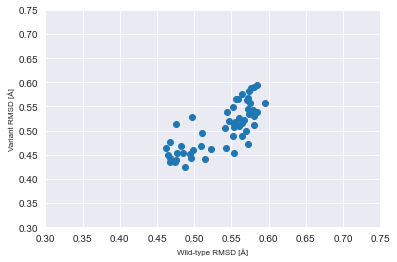

In [9]:
# RMSD plot: AF2 vs. PDB
plt.ylabel('Variant RMSD [Å]',fontsize=8)
plt.xlabel('Wild-type RMSD [Å]',fontsize=8)


plt.scatter(mut_2_wt_rmsd_list, mut_2_mut_rmsd_list)
plt.xlim(0.3,0.75)
plt.ylim(0.3,0.75)
plt.savefig("/Users/holger/Desktop/master_thesis/notebooks/figs/P00720_dis_scatter.png", dpi=1200)
correlations_vector(af2_rmsd_list, pdb_rmsd_list)

In [10]:
chi_1_af2_mean = []
chi_1_pdb_mean = []
rsn_N = list()
for i in range(len(filenames_af2)):
    rsn_N.append(mut[i])
    chi_1_af2_mean.append(np.mean(chi_1_af2[i]))
    chi_1_pdb_mean.append(np.mean(chi_1_pdb[i]))

for i in range(len(pos_af2[0])):
    if pos_af2[0][i][0] == int(rsn_N[0][3:-3]):
        print(i)

chi_1_mut_af2 = np.asarray([chi_1_af2[0][108],chi_1_af2[2][108],chi_1_af2[3][108],chi_1_af2[4][108],chi_1_af2[5][108],chi_1_af2[6][108],chi_1_af2[9][131],chi_1_af2[10][131],chi_1_af2[11][131],chi_1_af2[12][131],chi_1_af2[14][131],
                chi_1_af2[15][131],chi_1_af2[16][131],chi_1_af2[17][131],chi_1_af2[18][131],chi_1_af2[19][131],chi_1_af2[20][131],chi_1_af2[21][131],chi_1_af2[22][33],chi_1_af2[23][33],chi_1_af2[27][33],chi_1_af2[29][71],
                chi_1_af2[30][71],chi_1_af2[32][71],chi_1_af2[33][71],chi_1_af2[34][71],chi_1_af2[35][71],chi_1_af2[37][71],chi_1_af2[38][71],chi_1_af2[39][71],chi_1_af2[40][71],chi_1_af2[41][71],chi_1_af2[42][71],
                chi_1_af2[43][129],chi_1_af2[44][82],chi_1_af2[45][127],chi_1_af2[46][124],chi_1_af2[47][50],chi_1_af2[48][95],chi_1_af2[52][88]], dtype=np.float32)

chi_1_mut_pdb = np.asarray([chi_1_pdb[0][108],chi_1_pdb[2][108],chi_1_pdb[3][108],chi_1_pdb[4][108],chi_1_pdb[5][108],chi_1_pdb[6][108],chi_1_pdb[9][131],chi_1_pdb[10][131],chi_1_pdb[11][131],chi_1_pdb[12][131],chi_1_pdb[14][131],
                chi_1_pdb[15][131],chi_1_pdb[16][131],chi_1_pdb[17][131],chi_1_pdb[18][131],chi_1_pdb[19][131],chi_1_pdb[20][131],chi_1_pdb[21][131],chi_1_pdb[22][33],chi_1_pdb[23][33],chi_1_pdb[27][33],chi_1_pdb[29][33],
                chi_1_pdb[30][71],chi_1_pdb[32][71],chi_1_pdb[33][71],chi_1_pdb[34][71],chi_1_pdb[35][71],chi_1_pdb[37][71],chi_1_pdb[38][71],chi_1_pdb[39][71],chi_1_pdb[40][71],chi_1_pdb[41][71],chi_1_pdb[42][71],
                chi_1_pdb[43][129],chi_1_pdb[44][82],chi_1_pdb[45][127],chi_1_pdb[46][124],chi_1_pdb[47][50],chi_1_pdb[48][95],chi_1_pdb[52][88]], dtype=np.float32)

chi_1_mut_af2[chi_1_mut_af2 <= -120] += 360
chi_1_mut_pdb[chi_1_mut_pdb <= -120] += 360
#from collections import Counter
#Counter(rsn_N)

108


Pearson's correlation coefficient between data:  0.8884621018675184
Spearman's correlation coefficient bewteen data:  0.7681050656660413


[0.8884621018675184, 0.7681050656660413]

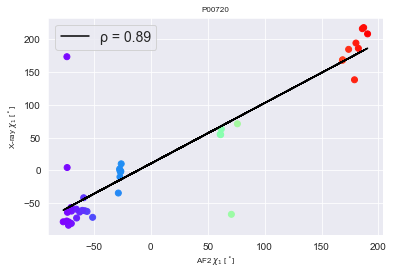

In [11]:
plt.title('P00720',fontsize=8)
plt.ylabel('X-ray $\chi_1$ [$^\circ$]',fontsize=8)
plt.xlabel('AF2 $\chi_1$ [$^\circ$]',fontsize=8)
trend = np.polyfit(chi_1_mut_af2,chi_1_mut_pdb,1)
trendpoly = np.poly1d(trend) 
plt.scatter(chi_1_mut_af2, chi_1_mut_pdb, c=chi_1_mut_af2, cmap='rainbow')
plt.plot(chi_1_mut_af2,trendpoly(chi_1_mut_af2), c='black', label = 'ρ = 0.89')
plt.legend(fontsize=14)
plt.savefig('/Users/holger/Desktop/master_thesis/notebooks/figs/chi1_mut_rainbow_P00720.png', dpi=1200, bbox_inches = 'tight')

correlations_vector(np.array(chi_1_mut_af2),np.array(chi_1_mut_pdb))



Pearson's correlation coefficient between data:  0.027558981336252904
Spearman's correlation coefficient bewteen data:  0.01945891714317796


[0.027558981336252904, 0.01945891714317796]

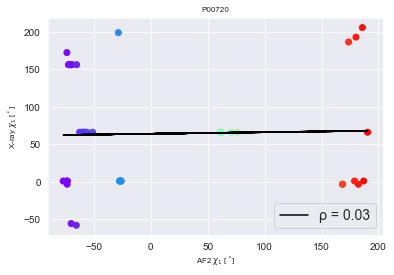

In [12]:
# Same plot as above but for wt
chi_1_angles_wt, _ = get_chi1_angles('/Users/holger/Desktop/master_thesis/data/arodz12/pdbs_P00720/0_2lzm.pdb')

chi_1_angles_wt = conv_to_np_arr_old(chi_1_angles_wt)


chi_1_mut_af2 = np.asarray([chi_1_af2[0][108],chi_1_af2[2][108],chi_1_af2[3][108],chi_1_af2[4][108],chi_1_af2[5][108],chi_1_af2[6][108],chi_1_af2[9][131],chi_1_af2[10][131],chi_1_af2[11][131],chi_1_af2[12][131],chi_1_af2[14][131],
                chi_1_af2[15][131],chi_1_af2[16][131],chi_1_af2[17][131],chi_1_af2[18][131],chi_1_af2[19][131],chi_1_af2[20][131],chi_1_af2[21][131],chi_1_af2[22][33],chi_1_af2[23][33],chi_1_af2[27][33],chi_1_af2[29][71],
                chi_1_af2[30][71],chi_1_af2[32][71],chi_1_af2[33][71],chi_1_af2[34][71],chi_1_af2[35][71],chi_1_af2[37][71],chi_1_af2[38][71],chi_1_af2[39][71],chi_1_af2[40][71],chi_1_af2[41][71],chi_1_af2[42][71],
                chi_1_af2[43][129],chi_1_af2[44][82],chi_1_af2[45][127],chi_1_af2[46][124],chi_1_af2[47][50],chi_1_af2[48][95],chi_1_af2[52][88]], dtype=np.float32)

chi_1_mut_wt = np.asarray([chi_1_angles_wt[0][108],chi_1_angles_wt[0][108],chi_1_angles_wt[0][108],chi_1_angles_wt[0][108],chi_1_angles_wt[0][108],chi_1_angles_wt[0][108],chi_1_angles_wt[0][131],chi_1_angles_wt[0][131],chi_1_angles_wt[0][131],chi_1_angles_wt[0][131],chi_1_angles_wt[0][131],
                chi_1_angles_wt[0][131],chi_1_angles_wt[0][131],chi_1_angles_wt[0][131],chi_1_angles_wt[0][131],chi_1_angles_wt[0][131],chi_1_angles_wt[0][131],chi_1_angles_wt[0][131],chi_1_angles_wt[0][33],chi_1_angles_wt[0][33],chi_1_angles_wt[0][33],chi_1_angles_wt[0][33],
                chi_1_angles_wt[0][71],chi_1_angles_wt[0][71],chi_1_angles_wt[0][71],chi_1_angles_wt[0][71],chi_1_angles_wt[0][71],chi_1_angles_wt[0][71],chi_1_angles_wt[0][71],chi_1_angles_wt[0][71],chi_1_angles_wt[0][71],chi_1_angles_wt[0][71],chi_1_angles_wt[0][71],
                chi_1_angles_wt[0][129],chi_1_angles_wt[0][82],chi_1_angles_wt[0][127],chi_1_angles_wt[0][124],chi_1_angles_wt[0][50],chi_1_angles_wt[0][95],chi_1_angles_wt[0][88]], dtype=np.float32)

chi_1_mut_af2[chi_1_mut_af2 <= -120] += 360
chi_1_mut_wt[chi_1_mut_wt <= -120] += 360
plt.title('P00720',fontsize=8)
plt.ylabel('X-ray $\chi_1$ [$^\circ$]',fontsize=8)
plt.xlabel('AF2 $\chi_1$ [$^\circ$]',fontsize=8)
trend = np.polyfit(chi_1_mut_af2,chi_1_mut_wt,1)
trendpoly = np.poly1d(trend) 
plt.scatter(chi_1_mut_af2, chi_1_mut_wt, c=chi_1_mut_af2, cmap='rainbow')
plt.plot(chi_1_mut_af2,trendpoly(chi_1_mut_af2), c='black', label = 'ρ = 0.03')
plt.legend(fontsize=14)
plt.savefig('/Users/holger/Desktop/master_thesis/notebooks/figs/chi1_wt_rainbow_P00720.png', dpi=1200, bbox_inches = 'tight')
correlations_vector(np.array(chi_1_mut_af2),np.array(chi_1_mut_wt))

Pearson's correlation coefficient between data:  0.8884621018675184
Spearman's correlation coefficient bewteen data:  0.7681050656660413


[0.8884621018675184, 0.7681050656660413]

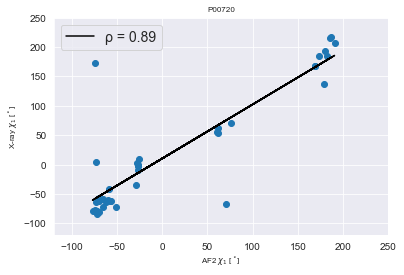

In [13]:
plt.title('P00720',fontsize=8)
plt.ylabel('X-ray $\chi_1$ [$^\circ$]',fontsize=8)
plt.xlabel('AF2 $\chi_1$ [$^\circ$]',fontsize=8)
trend = np.polyfit(chi_1_mut_af2,chi_1_mut_pdb,1)
trendpoly = np.poly1d(trend) 
plt.scatter(chi_1_mut_af2, chi_1_mut_pdb)
plt.xlim(-120,250)
plt.ylim(-120,250)
plt.plot(chi_1_mut_af2,trendpoly(chi_1_mut_af2), c='black', label = 'ρ = 0.89')
plt.legend(fontsize=14, )
plt.savefig('/Users/holger/Desktop/master_thesis/notebooks/figs/chi1_mut_P00720.png', dpi=1200, bbox_inches = 'tight')

correlations_vector(np.array(chi_1_mut_af2),np.array(chi_1_mut_pdb))

In [14]:
# Do this for all
plddt_idx = list()
for i in range(len(pos_af2)):
    tmp = np.asarray([pos_af2[0][i][0] for i in range(len(pos_af2[0]))])
    plddt_idx.append(tmp)
plddt_idx = np.vstack(np.asarray(plddt_idx)-1)
plddt = np.asarray(plddt)
plddt_indexed = [np.append(plddt[i][plddt_idx[i]],np.array([np.mean(plddt_idx[i],axis=0)])) for i in range(len(plddt))]

plddt_indexed = np.vstack(plddt_indexed)

plddt_indexed.shape

(54, 139)

(139,) (139,)


/var/folders/38/bl4yf01j4jx6h6m2ctkbjd3r0000gn/T/ipykernel_15898/822840429.py:159: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sm, label='pLDDT')


(139,) (139,)
Pearson's correlation coefficient between data:  0.8591091907689683
Spearman's correlation coefficient bewteen data:  0.7546226372938916


[0.8591091907689683, 0.7546226372938916]

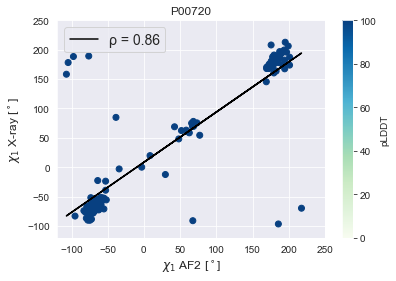

In [15]:
# Scatter plot chi_1_af2 vs. chi_1_pdb
#circ_meanscatter_plot(chi_1_af2, chi_1_pdb,plddt)
circ_meanscatter_plot(chi_1_af2,chi_1_pdb_wt, plddt)


In [16]:
#scatter_plot(chi_1_af2, chi_1_pdb)

/Users/holger/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


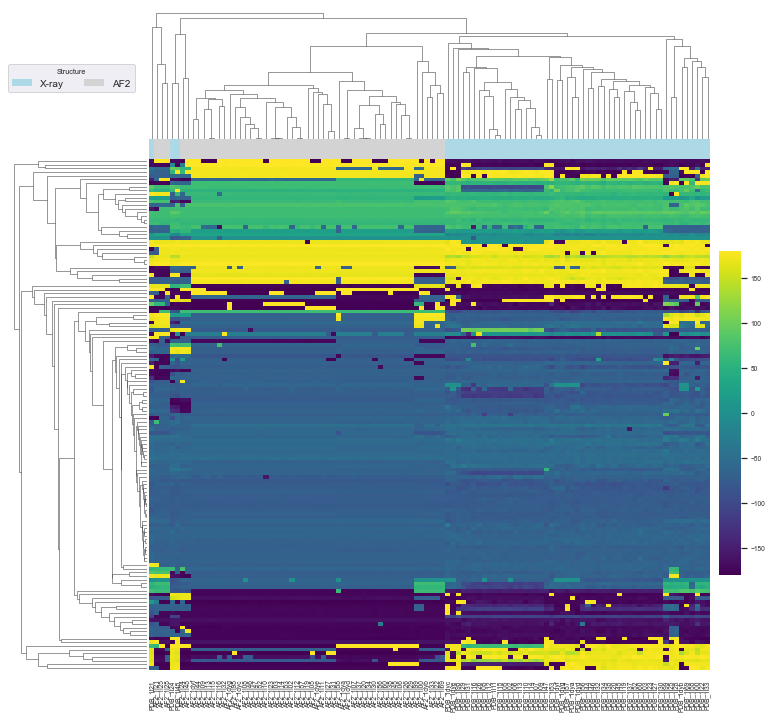

In [17]:
X=np.stack(conv_to_np_arr_old(chi_1_af2)).reshape(-1,139)
Y=np.stack(conv_to_np_arr_old(chi_1_pdb)).reshape(-1,139)

dat = np.vstack((Y,X)).T
filenames_combined = filenames_pdb+filenames_af2
names = filenames_combined

filenames_combined = filenames_pdb+filenames_af2
names = filenames_combined
filenames_combined = ["AF2_" + name[7:11] if name.startswith("P00720") else "PDB_"+ name[0:4] for name in names]
df_test = pd.DataFrame(dat, index=[i for i in range(139)], columns=filenames_combined)


dataset = ["AF2" if name.startswith("P00720") else "X-ray" for name in names]
a = {'AF2': 'lightgray', 'X-ray': 'lightblue'}
colors = lambda x: a[x]
col_colors = list(map(colors, dataset))
sns.set(font_scale = 0.60)
cm=sns.clustermap(df_test,
               method='average',
               cbar_pos = (1, .20, .03, .45),
               yticklabels=False,
               col_colors=col_colors,
               xticklabels=True,
               #standard_scale=1,
               annot_kws={"size": 1},
               cmap='viridis',
               vmin=-180,
               vmax=180)

# Add legends
for label in ['X-ray', 'AF2']:
    cm.ax_col_dendrogram.bar(0, 0, color=a[label], label=label, linewidth=0);
l1 = cm.ax_col_dendrogram.legend(title='Structure', loc="center", ncol=5, bbox_to_anchor=(0.1, 0.89), bbox_transform=gcf().transFigure, prop={'size': 10})


plt.savefig('/Users/holger/Desktop/master_thesis/notebooks/figs/clustermap_chi1_P00720.png', dpi=1200, bbox_inches = 'tight')

Pearson's correlation coefficient between data:  0.1640880968427228
Spearman's correlation coefficient bewteen data:  0.18635410710882405


[0.1640880968427228, 0.18635410710882405]

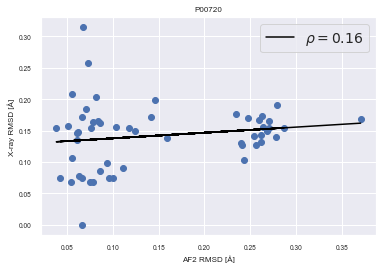

In [18]:
# RMSD plot: AF2 vs. PDB
plt.title('P00720',fontsize=8)
plt.ylabel('X-ray RMSD [Å]',fontsize=8)
plt.xlabel('AF2 RMSD [Å]',fontsize=8)
trend = np.polyfit(af2_rmsd_list,pdb_rmsd_list,1)
trendpoly = np.poly1d(trend) 
plt.scatter(af2_rmsd_list, pdb_rmsd_list)
plt.plot(af2_rmsd_list,trendpoly(af2_rmsd_list), c='black', label = r'$\rho = 0.16$')
plt.legend(fontsize=14)
plt.savefig('/Users/holger/Desktop/master_thesis/notebooks/figs/rmsd_P00720.png', dpi=1200, bbox_inches = 'tight')
correlations_vector(af2_rmsd_list, pdb_rmsd_list)

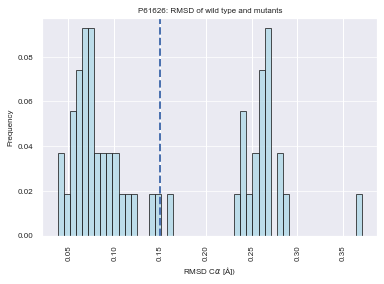

In [19]:
# Create histogram of RMSDs
output_variance_np = np.asarray(af2_rmsd_list)
hist,bin_edges = np.histogram(af2_rmsd_list)
weights = np.ones_like(af2_rmsd_list) / len(af2_rmsd_list)
n, bins, patches = plt.hist(af2_rmsd_list, 50, weights = weights, facecolor='lightblue', edgecolor='k', alpha=0.75)
plt.grid(axis='y', alpha=0.75)
plt.xlabel(r'RMSD C$\alpha$ [Å])',fontsize=8)
plt.ylabel('Frequency',fontsize=8)
plt.xticks(fontsize=8,rotation='vertical')
plt.yticks(fontsize=8)
plt.ylabel('Frequency',fontsize=8)
plt.title('P61626: RMSD of wild type and mutants',fontsize=8)
plt.axvline(np.mean(af2_rmsd_list), color='b', linestyle='dashed', linewidth=2)
#plt.savefig('/Users/holgerchristiannyelandehlers/Desktop/master_thesis/notebooks/figs/rmsd_dis_P0A7Y4.png', dpi=1200)

In [20]:
# Concat dataframes
df_af2 = pd.DataFrame (af2_rmsd_list, columns = ['rmsd_af2'])
df_pdb = pd.DataFrame (pdb_rmsd_list, columns = ['rmsd_pdb'])
df_mut2mut = pd.DataFrame (mut_2_mut_rmsd_list, columns = ['rmsd'])
df_mut2wt = pd.DataFrame (mut_2_wt_rmsd_list, columns = ['rmsd'])

df_concated = pd.concat([df_af2, df_pdb], axis=1)
a = dict(zip(np.unique(df_concated.rmsd_af2), np.array(['g','skyblue'])))
#df_concated.describe()
df_pdb['rmsd_pdb'].mean()

0.14205071641945755

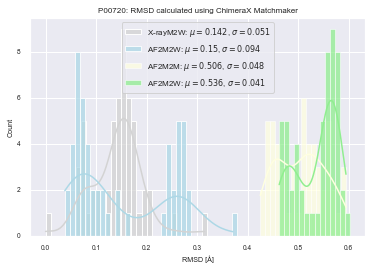

In [21]:
sns.histplot(df_pdb,x="rmsd_pdb", binwidth=0.01, alpha=0.75, kde=True, color="lightgrey", label="X-rayM2W: $\mu = {}$, $\sigma = {}$".format(round(df_pdb["rmsd_pdb"].mean(),3),round(df_pdb["rmsd_pdb"].std(),3)))
sns.histplot(df_af2, x="rmsd_af2", binwidth=0.01, alpha=0.75, kde=True, color='lightblue', label="AF2M2W: $\mu = {}$, $\sigma = {}$".format(round(df_af2["rmsd_af2"].mean(),3),round(df_af2["rmsd_af2"].std(),3)))
sns.histplot(df_mut2mut,x="rmsd", binwidth=0.01, alpha=0.75, kde=True, color="lightyellow", label="AF2M2M: $\mu = {}$, $\sigma = {}$".format(round(df_mut2mut["rmsd"].mean(),3),round(df_mut2mut["rmsd"].std(),3)))
sns.histplot(df_mut2wt, x="rmsd", binwidth=0.01, alpha=0.75, kde=True, color='lightgreen', label="AF2M2W: $\mu = {}$, $\sigma = {}$".format(round(df_mut2wt["rmsd"].mean(),3),round(df_mut2wt["rmsd"].std(),3)))

plt.legend(fontsize=8)
plt.title('P00720: RMSD calculated using ChimeraX Matchmaker',fontsize=8)

plt.xlabel("RMSD [Å]")
plt.ylabel("Count")
plt.savefig("/Users/holger/Desktop/master_thesis/notebooks/figs/P00720_dis.pdf")
plt.show()

In [22]:
# Define consts
DATA_PATH_MUT_AF2_2wt = '/Users/holger/Desktop/master_thesis/data/results_rmsd/results_rmsd_af2/results_rmsd_P00720_mut2wt/'
DATA_PATH_MUT_PDB_2mut = '/Users/holger/Desktop/master_thesis/data/results_rmsd/results_rmsd_af2/results_rmsd_P00720_mut2mut/'
DATA_PATH_PDB = '/Users/holger/Desktop/master_thesis/data/arodz12/pdbs_P61626/'
DATA_PATH_AF2 = '/Users/holger/Desktop/master_thesis/data/results_af2/P61626/'
arodz_pdbs = ['1dya', '1dyb', '1dyc', '1dyd', '1dye', '1dyf', '1dyg', '1l00',
       '1l02', '1l03', '1l05', '1l06', '1l07', '1l08', '1l09', '1l10',
       '1l11', '1l12', '1l13', '1l14', '1l15', '1l16', '1l19', '1l20',
       '1l21', '1l22', '1l23', '1l24', '1l25', '1l26', '1l27', '1l28',
       '1l29', '1l30', '1l31', '1l32', '1l33', '1l34', '1l37', '1l38',
       '1l44', '1l45', '1l46', '1l47', '1l48', '1l52', '1l53', '1l56',
       '1l57', '1l58', '1l60', '1l69', '1l98', '1l99']
# Get RMSDs
#af2_rmsd_list_2wt, mut = load_rmsd(DATA_PATH_MUT_AF2_2wt, arodz_pdbs)
pdb_rmsd_list_2mut, _ = load_rmsd(DATA_PATH_MUT_PDB_2mut, arodz_pdbs)
dir_list = sorted(os.listdir(DATA_PATH_MUT_AF2_2wt))
af2_rmsd_list_2wt = np.zeros(len(dir_list))
mut_list = [0]*len(dir_list)
for i in range(len(dir_list)):
    df = pd.read_csv(DATA_PATH_MUT_AF2_2wt + dir_list[i])['rmsd'][0]
    af2_rmsd_list_2wt[i] = df

0.5055709948524781
Pearson's correlation coefficient between data:  0.7702430672713338
Spearman's correlation coefficient bewteen data:  0.7699256718124642


[0.7702430672713338, 0.7699256718124642]

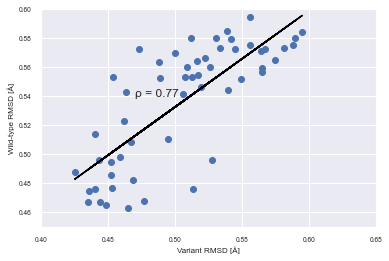

In [33]:
# RMSD plot: AF2 vs. PDB
fig, ax = plt.subplots()
print(np.mean(pdb_rmsd_list_2mut))
plt.ylabel('Wild-type RMSD [Å]',fontsize=8)
plt.xlabel('Variant RMSD [Å]',fontsize=8)
trend = np.polyfit(pdb_rmsd_list_2mut,af2_rmsd_list_2wt,1)
trendpoly = np.poly1d(trend) 
plt.xlim([0.4, 0.65])
plt.ylim([0.45, 0.6])
plt.text(0.47, 0.54,'ρ = 0.77', size=12)
plt.scatter(pdb_rmsd_list_2mut, af2_rmsd_list_2wt)
plt.plot(pdb_rmsd_list_2mut,trendpoly(pdb_rmsd_list_2mut), c='black')
plt.savefig("/Users/holger/Desktop/master_thesis/notebooks/figs/rmsd_plot_P00720_af2_vs_mut_wt.pdf", dpi=1200)
correlations_vector(pdb_rmsd_list_2mut, af2_rmsd_list_2wt)

In [24]:
print(df_af2["rmsd_af2"].mean())
print(df_pdb['rmsd_pdb'].mean())

0.1501993205385918
0.14205071641945755


In [25]:
df_pdb

,rmsd_pdb
0,1.543003e-01
1,1.220695e-14
2,1.543003e-01
3,1.539666e-01
4,1.533662e-01
5,1.713034e-01
6,1.341971e-01
7,1.488999e-01
8,1.843102e-01
9,2.568039e-01
